## Скачаем необходимые данные и пакеты

In [83]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

%precision 4

'%.4f'

In [53]:
data = pd.read_csv('clean_data_MSK.csv', sep=':')
data.iloc[:, :13].head()

,lighting,long,lat,region,category,date,severity,dead,injured,n_participants,dr_exp,w_percent,Температура выше +30С
0,Светлое время суток,55.616777,37.706516,Орехово-Борисово Северное,Наезд на пешехода,2020-03-24 13:06:00,Легкий,0,1,2,[28],0.0,0
1,Светлое время суток,55.841157,37.489332,Головинский,Столкновение,2018-09-15 11:00:00,Легкий,0,1,2,"[20, 6]",0.5,0
2,"В темное время суток, освещение включено",55.713332,37.658944,Даниловский,Наезд на пешехода,2016-04-14 21:25:00,Легкий,0,1,2,[],NaN,0
3,Светлое время суток,55.655243,37.414176,Солнцево,Столкновение,2019-06-20 18:15:00,Легкий,0,1,2,"[12, 1]",0.5,0
4,Светлое время суток,55.756493,37.789315,Перово,Наезд на пешехода,2016-04-04 11:50:00,Легкий,0,1,2,[15],0.0,0


## I. Визуализируем важные временные ряды

### 1) Количество погибших в автокатастрофах с 2015 по 2020 по месяца

In [54]:
df1 = data[['dead']].copy()
df1['dates_monthly'] = pd.PeriodIndex(data['date'], freq='M')
df1 = df1.sort_values(['dates_monthly'])
gb = df1.groupby('dates_monthly').sum()

months = set([*map(lambda x: x.split()[0][:7], data['date'])])
labels_m = [dt if i % 4 == 0 else '' for i, dt in enumerate(sorted(list(months)))]

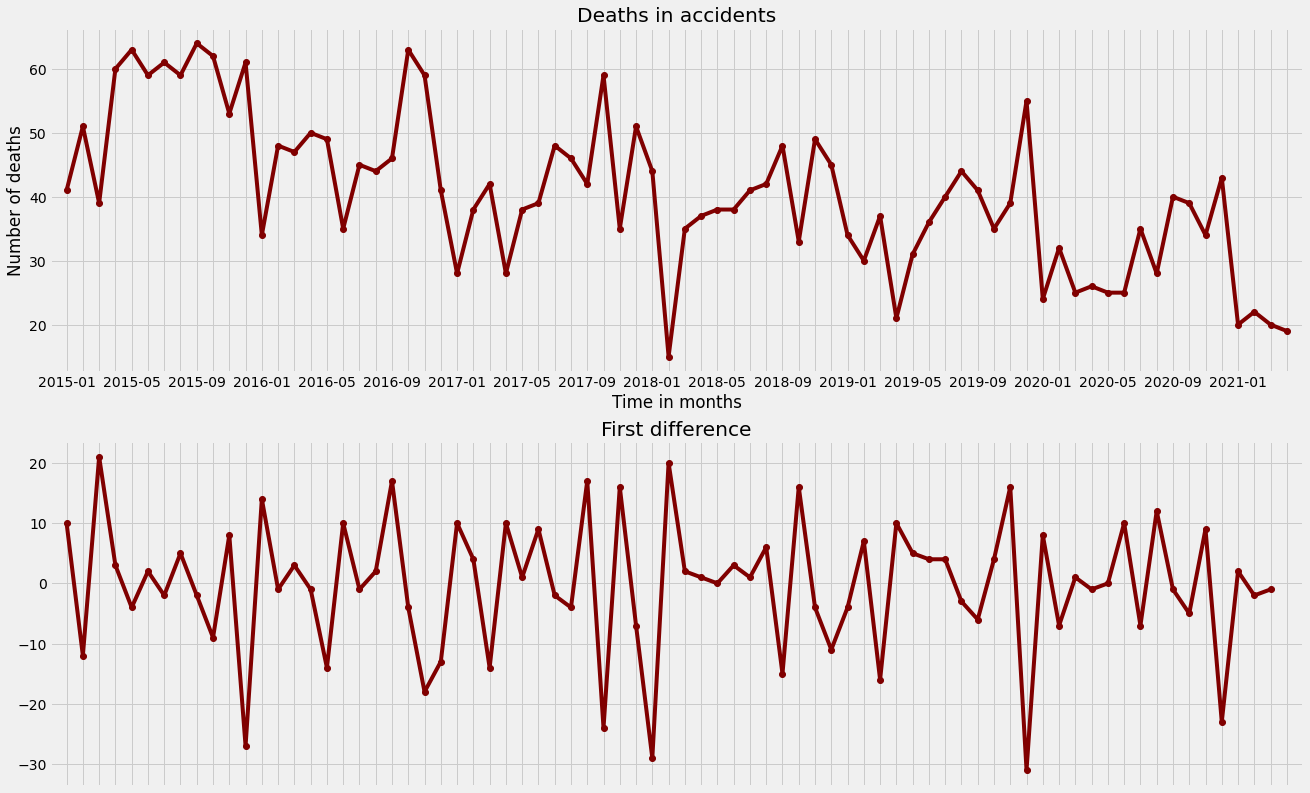

In [55]:
plt.style.use('fivethirtyeight')

_, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 13))

ax1.plot(gb.dead.values, marker='o', c='maroon')
ax1.set_xticks(ticks = np.arange(76))
ax1.set_xticklabels(labels_m)
ax1.set_xlabel('Time in months')
ax1.set_ylabel('Number of deaths')
ax1.set_title('Deaths in accidents')
ax1.set_xlim(-1, 76)

ax2.plot(gb.dead.values[1:] - gb.dead.values[:-1], marker='o', c='maroon')
ax2.set_xticks(ticks = np.arange(76))
ax2.set_xticklabels(['']*76)
ax2.set_title('First difference')
ax2.set_xlim(-1, 76)
plt.show()

The original series is nonstationry: it has seasonality and a trend, however the first difference seems to be stationary

### 2) Количество погибших в автокатастрофах в течение дня и количество автокатастров в течение дня

In [56]:
# making labels for every hour
hours = data['date'].apply(lambda x: x.split()[1][:2]+':00').values
labels_h = sorted(list(np.unique(hours)))

# making a slicec of a dataset 
slice2 = data[['dead']].copy()
slice2['Num_accidents'] = 1
slice2['hours'] = hours
slice2 = slice2.sort_values(['hours'])

# grouping by mean and sum
gb_mean = slice2.groupby('hours').mean()
gb_sum = slice2.groupby('hours').sum()

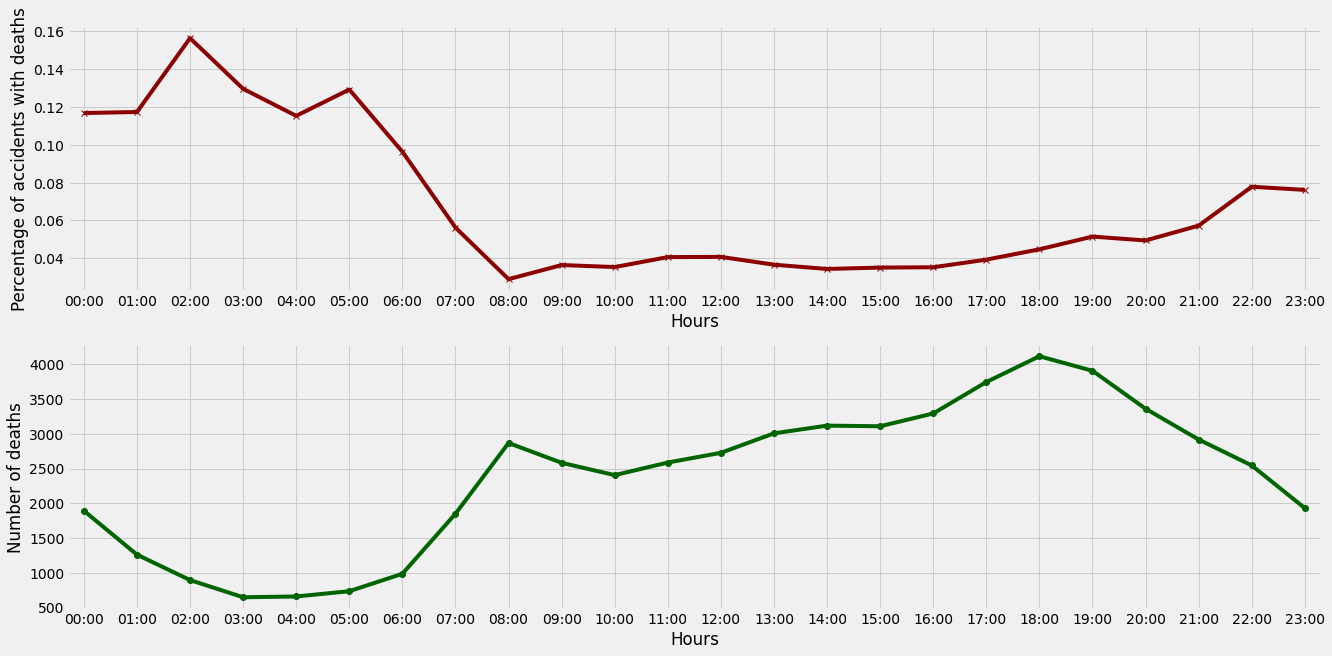

In [57]:
plt.style.use('fivethirtyeight')
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

ax1.plot(gb_mean.dead.values, marker='x', c='darkred')
ax1.set_xticks(ticks=np.arange(24))
ax1.set_xticklabels(labels_h)
ax1.set_xlabel('Hours')
ax1.set_ylabel('Percentage of accidents with deaths')
ax1.set_xlim(-0.3, 23.3)

ax2.plot(gb_sum.Num_accidents.values, marker='o', c='darkgreen')
ax2.set_xticks(ticks=np.arange(24))
ax2.set_xticklabels(labels_h)
ax2.set_xlabel('Hours')
ax2.set_ylabel('Number of deaths')
ax2.set_xlim(-0.3, 23.3)

plt.show()

## II. Создаем модель для предсказывания количества смертей

In [58]:
series = gb.dead.values

# train_test_split
train, test = series[1:64], series[64:]

# first differences train and test
diff = series[1:] - series[:-1]
dtrain, dtest = diff[:-12], diff[-12:]

len(train), len(test), len(dtrain), len(dtest)

(63, 12, 63, 12)

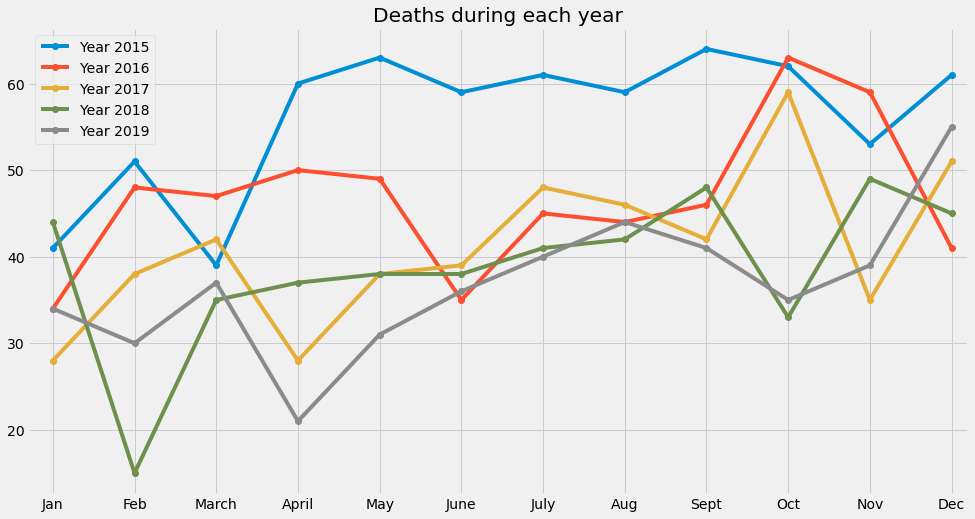

In [62]:
months = ['Jan', 'Feb', 'March', "April", 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

plt.figure(figsize=(15, 8))
plt.plot(series[:12], marker='o', label='Year 2015')
plt.plot(series[12:24], marker='o', label='Year 2016')
plt.plot(series[24:36], marker='o', label='Year 2017')
plt.plot(series[36:48], marker='o', label='Year 2018')
plt.plot(series[48:60], marker='o', label='Year 2019')
plt.title('Deaths during each year')
plt.xticks(ticks=np.arange(12), labels=months)
plt.xlim(-0.3, 11.2)
plt.legend()
plt.show()

In [63]:
import nest_asyncio
nest_asyncio.apply()

import stan

We are going to use MA process for the first difference

In [170]:
_ARMA101 = """
data {
  int<lower=3> T;  // number of observations
  vector[T] dy;     // observation at time T
}
parameters {
  real mu;              // mean
  real beta;            // term by y_{t-1}
  real<lower=0> sigma;  // error scale
  real theta;      // lag coefficients
}
transformed parameters {
  vector[T] epsilon;    // error terms
  epsilon[1] = dy[1] - mu;
  for (t in 2:T)
    epsilon[t] = (dy[t] - mu
                    - beta * dy[t - 1]
                    - theta * epsilon[t - 1] );
}
model {
  mu ~ normal(0, 2.5);
  beta ~ normal(0, 2.5);
  theta ~ normal(0, 2.5);
  sigma ~ normal(0, 1);
  for (t in 2:T)
    dy[t] ~ normal(mu
                  + beta * dy[t - 1]
                  + theta * epsilon[t - 1],
                  sigma);
}"""

In [168]:
data = {
    'T': 63,
    'dy': dtrain
}

In [171]:
posterior = stan.build(_ARMA101, data=data)
fit = posterior.sample(num_samples=1000)

Building...
Found model in cache. Done.
Sampling...
    0/8000 [>---------------------------]   0%  1 sec/0     
 8000/8000 [============================] 100%  1 sec/0   Messages received during sampling:
  Gradient evaluation took 4.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.46 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter is -inf, but must be finite! (in '/var/folders/pc/4112j_zx451_58mz9tnqpgr40000gn/T/httpstan_y0y5gq_0/model_46q7xzmt.stan', line 26, column 4 to line 29, column 25)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is ab

In [172]:
params = fit.to_frame()
params.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,beta,sigma,...,epsilon.54,epsilon.55,epsilon.56,epsilon.57,epsilon.58,epsilon.59,epsilon.60,epsilon.61,epsilon.62,epsilon.63
draws,,,,,,,,,,,,,,,,,,,,,
0,-205.798132,0.641756,0.297557,2.0,7.0,0.0,209.310618,-0.026739,0.246201,7.894815,...,5.554611,7.318236,1.675989,-3.944372,2.467311,16.941431,-21.869861,-1.177872,-9.849673,-4.832774
1,-205.798132,0.641756,0.297557,2.0,7.0,0.0,209.310618,-0.026739,0.246201,7.894815,...,5.554611,7.318236,1.675989,-3.944372,2.467311,16.941431,-21.869861,-1.177872,-9.849673,-4.832774
2,-205.798132,0.641756,0.297557,2.0,7.0,0.0,209.310618,-0.026739,0.246201,7.894815,...,5.554611,7.318236,1.675989,-3.944372,2.467311,16.941431,-21.869861,-1.177872,-9.849673,-4.832774
3,-205.798132,0.641756,0.297557,2.0,7.0,0.0,209.310618,-0.026739,0.246201,7.894815,...,5.554611,7.318236,1.675989,-3.944372,2.467311,16.941431,-21.869861,-1.177872,-9.849673,-4.832774
4,-204.505669,0.984695,0.297557,3.0,11.0,0.0,206.320330,-0.445461,0.197468,7.168902,...,7.464047,9.718775,4.550333,-1.265816,4.602021,19.393897,-17.959996,-0.022283,-8.152382,-3.794598


In [181]:
params = fit.to_frame()
mu = params['mu'].mean()
sigma = params['sigma'].mean()
beta = params['beta'].mean()
# beta2 = params['beta2'].mean()
th1 = params['theta'].mean()
# th2 = params['theta.2'].mean()
err1 = params['epsilon.62'].mean()
err2 = params['epsilon.63'].mean()
errs = [err1, err2]

In [182]:
np.random.seed(1)
dpred = [1]
for i in range(2, 14):
    dy = np.random.normal(loc = mu 
                                + beta * dpred[-1]
                                # + beta2 * dpred[-2] 
                                + th1 * errs[i - 1] 
                                # + th2 * errs[i - 2] 
                                , scale = sigma, size=100000)
    dpred += [dy]
    errs += [dy - dtest[i - 2]]
dpred = dpred[1:]
print(len(dpred))
assert len(dpred) == 12

12


In [183]:
pred = [25]
for dy in dpred:
    pred += [pred[-1] + dy]

pred = pred[1:]
assert len(pred) == 12

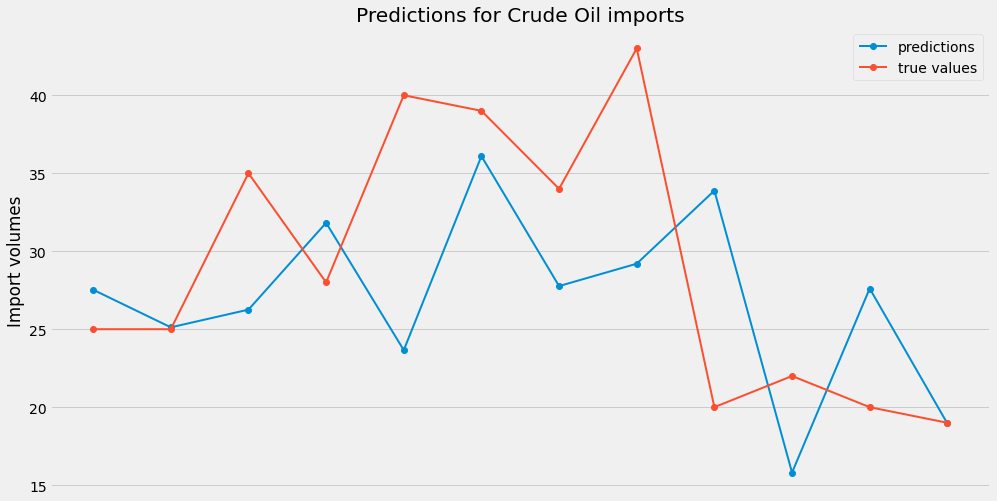

In [184]:
plt.figure(figsize=(15, 8))
plt.plot(np.array(pred).mean(axis=1), lw = 2, marker='o',  label='predictions')
plt.plot(test, lw = 2, marker='o',  label='true values')
plt.ylabel('Import volumes')
plt.xticks([])
plt.title('Predictions for Crude Oil imports')
plt.legend()
plt.show()

In [185]:
from sklearn.metrics import mean_absolute_percentage_error as mape

In [186]:
y_pred = np.array(pred).mean(axis=1)
y_true = test
mape(y_true, y_pred)

0.23650318403151763